In [1]:
import torch as th
from datasets import load_dataset
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
th.set_grad_enabled(False)
lmsys_test = load_dataset("Butanium/lmsys-chat-test-set-gemma")
%load_ext autoreload
%autoreload 2
TESTING = False

In [2]:
from nnterp import load_model

device_it = "cuda:0"
device_base = "cuda:1"
it_model = load_model(
    "google/gemma-2-2b-it",
    device_map=device_it,
    dispatch=True,
    tokenizer_kwargs={"padding_side": "right"},
)
base_model = load_model(
    "google/gemma-2-2b",
    device_map=device_base,
    dispatch=True,
    tokenizer_kwargs={"padding_side": "right"},
)
template_file = "../templates/gemma_chat_template.jinja"
with open(template_file, "r") as f:
    template = f.read()
it_model.tokenizer.chat_template = template
eot_token = it_model.tokenizer.convert_tokens_to_ids("<end_of_turn>")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Mask testing

In [3]:
conv = [
    {"role": "user", "content": "Hello, how are you?"},
    {"role": "assistant", "content": "I am fine, thank you!"},
    {"role": "user", "content": "What is your name?"},
    {"role": "assistant", "content": "I am a chatbot."},
    {"role": "user", "content": "What is the capital of France?"},
    {"role": "assistant", "content": "The capital of France is Paris."},
]
toks = it_model.tokenizer.apply_chat_template(
    [conv] * 10,
    return_assistant_tokens_mask=True,
    return_dict=True,
    truncation=True,
    max_length=30,
)

# display the text with assistant mask == 1 in red
for tok, mask in zip(toks["input_ids"][0], toks["assistant_masks"][0]):
    tok = it_model.tokenizer.decode(tok)
    if tok == "\n":
        tok = "\\n\n"
    if mask == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")

<bos><start_of_turn>user\n
Hello, how are you?<end_of_turn>\n
<start_of_turn>model\n
I am fine, thank you!<end_of_turn>\n
<start_of_turn>user\n
What is your

In [4]:
for tok, mask in zip(toks["input_ids"][0], toks["attention_mask"][0]):
    tok = it_model.tokenizer.decode(tok)
    if tok == "\n":
        tok = "\\n\n"
    if mask == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")

<bos><start_of_turn>user\n
Hello, how are you?<end_of_turn>\n
<start_of_turn>model\n
I am fine, thank you!<end_of_turn>\n
<start_of_turn>user\n
What is your

In [5]:
from tools.utils import tokenize_with_ctrl_mask, tokenize_with_ctrl_ids

toks = tokenize_with_ctrl_ids(
    [conv + conv] * 10,  # + [conv + conv],
    it_model.tokenizer,
    return_assistant_tokens_mask=True,
    return_dict=True,
    truncation=True,
    max_length=60,
    return_tensors="pt",
    padding=True,
)
assistant_mask = th.tensor(toks["assistant_masks"][0], dtype=th.bool)
transitions = assistant_mask[1:]  # != assistant_mask[:-1]
# control_mask = toks["ctrl_mask"]
control_mask = toks["ctrl_ids"]
print(len(toks["input_ids"][0]), len(control_mask[0]))
colors = [
    None,
    "43",
    "41",
    "42",
    "93",
    "94",
    "95",
    "96",
    "30",
    "31",
    "32",
    "33",
    "34",
    "35",
    "36",
]
for tok, mask in zip(toks["input_ids"][0], control_mask[0]):
    tok = it_model.tokenizer.decode(tok)
    if tok == "\n":
        tok = "\\n\n"
    if mask != 0:
        print(f"\033[{colors[mask]}m{tok}\033[0m", end="")
    else:
        print(tok, end="")

60 60
<bos><start_of_turn>user\n
Hello, how are you?<end_of_turn>\n
<start_of_turn>model\n
I am fine, thank you!<end_of_turn>\n
<start_of_turn>user\n
What is your name?<end_of_turn>\n
<start_of_turn>model\n
I am a chatbot.<end_of_turn>\n
<start_of_turn>user\n
What is the capital of France?<end_of_turn>\n
<start_of_turn>model\n
The

In [6]:
hack_template = open(
    "/root/repos/representation-structure-comparison/templates/gemma_chat_template_ctrl_tokens.jinja"
).read()
toks = it_model.tokenizer.apply_chat_template(
    [conv] * 10,  # + [conv + conv],
    return_assistant_tokens_mask=True,
    return_dict=True,
    truncation=True,
    max_length=25,
    return_tensors="pt",
    padding=True,
    chat_template=hack_template,
)
for tok, mask in zip(toks["input_ids"][0], toks["assistant_masks"][0]):
    tok = it_model.tokenizer.decode(tok)
    if tok == "\n":
        tok = "\\n\n"
    if mask == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")

<bos><start_of_turn>user\n
Hello, how are you?<end_of_turn>\n
<start_of_turn>model\n
I am fine, thank you!<end_of_turn>\n
<start_of_turn>

## Norm diff exp

In [7]:
from tqdm.auto import trange
from torchmetrics.aggregation import MeanMetric, MaxMetric, MinMetric
from collections import defaultdict
from nnterp.nnsight_utils import get_num_layers, get_layer_output

num_layers = get_num_layers(it_model)
batch_size = 8
th.set_grad_enabled(False)
data = lmsys_test["train"]["conversation"]
results = [defaultdict(lambda: defaultdict(MeanMetric)) for _ in range(num_layers)]
results_max = [defaultdict(lambda: defaultdict(MaxMetric)) for _ in range(num_layers)]
results_min = [defaultdict(lambda: defaultdict(MinMetric)) for _ in range(num_layers)]


def add_results(control_norms, other_norms, other_no_bos_norms, model):
    for i, (control_norm, other_norm, other_no_bos_norm) in enumerate(
        zip(control_norms, other_norms, other_no_bos_norms)
    ):
        results[i][model]["control"].update(control_norm)
        results[i][model]["other"].update(other_norm)
        results[i][model]["other_no_bos"].update(other_no_bos_norm)
        results_max[i][model]["control"].update(control_norm)
        results_max[i][model]["other"].update(other_norm)
        results_max[i][model]["other_no_bos"].update(other_no_bos_norm)
        results_min[i][model]["control"].update(control_norm)
        results_min[i][model]["other"].update(other_norm)
        results_min[i][model]["other_no_bos"].update(other_no_bos_norm)

max_num_tokens = 100_000 if not TESTING else 100
num_tokens = 0
pbar = tqdm(total=max_num_tokens, desc="Processing Tokens")
for i in trange(0, len(data), batch_size):
    batch_data = data[i : i + batch_size]
    # run a forward pass on both pytorch models
    # Split models across GPUs
    batch = tokenize_with_ctrl_ids(
        batch_data,
        it_model.tokenizer,
        return_assistant_tokens_mask=True,
        return_dict=True,
        truncation=True,
        max_length=1024,
        return_tensors="pt",
        padding=True,
    )

    control_mask = batch["ctrl_mask"]
    other_mask = ~control_mask & batch["attention_mask"].bool()
    other_no_bos_mask = other_mask.clone()
    other_no_bos_mask[:, 0] = False
    with it_model.trace(batch):
        control_norms = []
        other_norms = []
        other_no_bos_norms = []
        it_output = []
        for i in range(num_layers):
            it_output.append(get_layer_output(it_model, i).save())
            norms = it_output[-1].norm(dim=-1)
            control_norms.append(norms[control_mask].save())
            other_norms.append(norms[other_mask].save())
            other_no_bos_norms.append(norms[other_no_bos_mask].save())

    add_results(control_norms, other_norms, other_no_bos_norms, "it")
    with base_model.trace(batch):
        control_norms = []
        other_norms = []
        other_no_bos_norms = []
        base_output = []
        for i in range(num_layers):
            base_output.append(get_layer_output(base_model, i).save())
            norms = base_output[-1].norm(dim=-1)
            control_norms.append(norms[control_mask].save())
            other_norms.append(norms[other_mask].save())
            other_no_bos_norms.append(norms[other_no_bos_mask].save())
    add_results(control_norms, other_norms, other_no_bos_norms, "base")

    diffs_norms = [
        (it_output - base_output.to(it_output.device)).norm(dim=-1)
        for it_output, base_output in zip(it_output, base_output)
    ]
    control_diffs = [diffs_norm[control_mask].cpu() for diffs_norm in diffs_norms]
    other_diffs = [diffs_norm[other_mask].cpu() for diffs_norm in diffs_norms]
    other_no_bos_diffs = [
        diffs_norm[other_no_bos_mask].cpu() for diffs_norm in diffs_norms
    ]
    add_results(control_diffs, other_diffs, other_no_bos_diffs, "diff")
    num_new_tokens = min(control_mask.sum().item(), other_mask.sum().item())
    num_tokens += num_new_tokens
    pbar.update(num_new_tokens)
    if num_tokens >= max_num_tokens:
        break

Processing Tokens:   0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.


The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


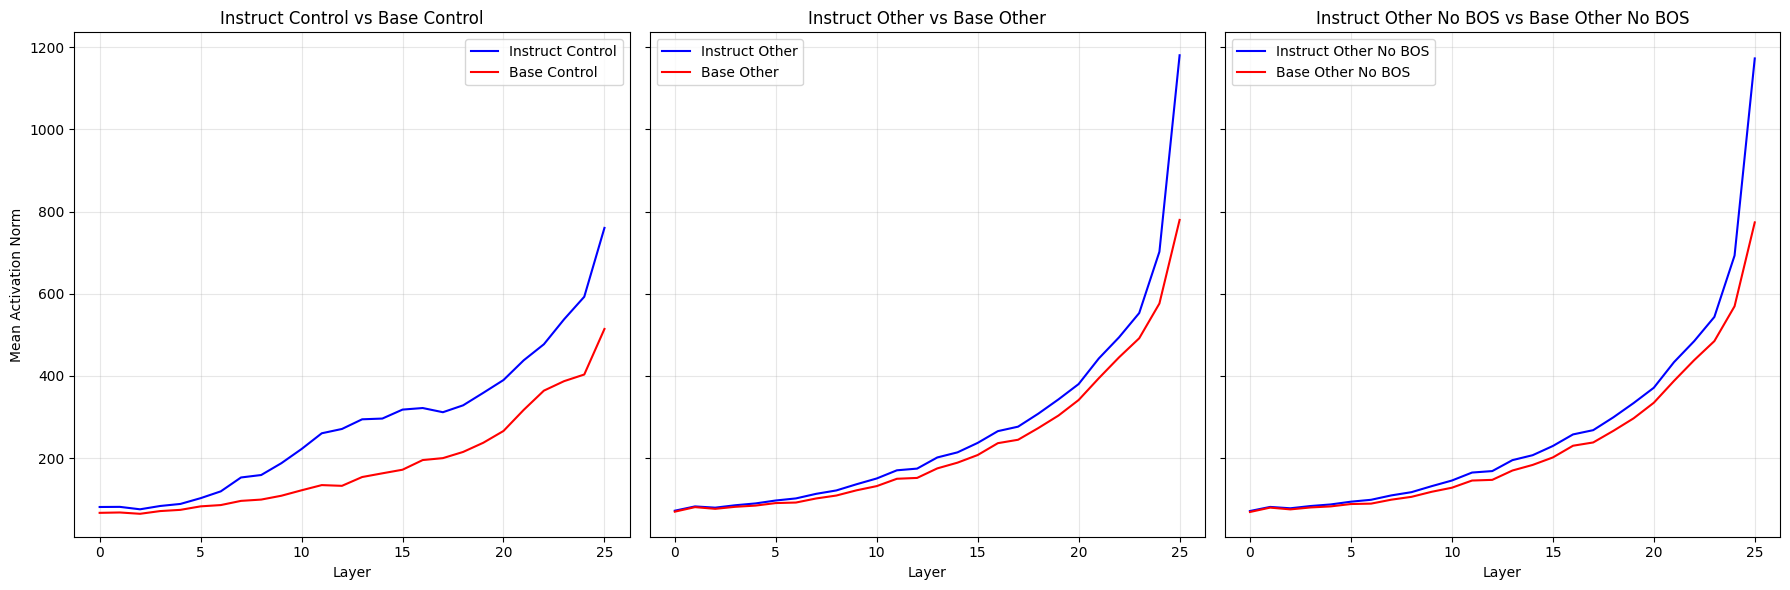

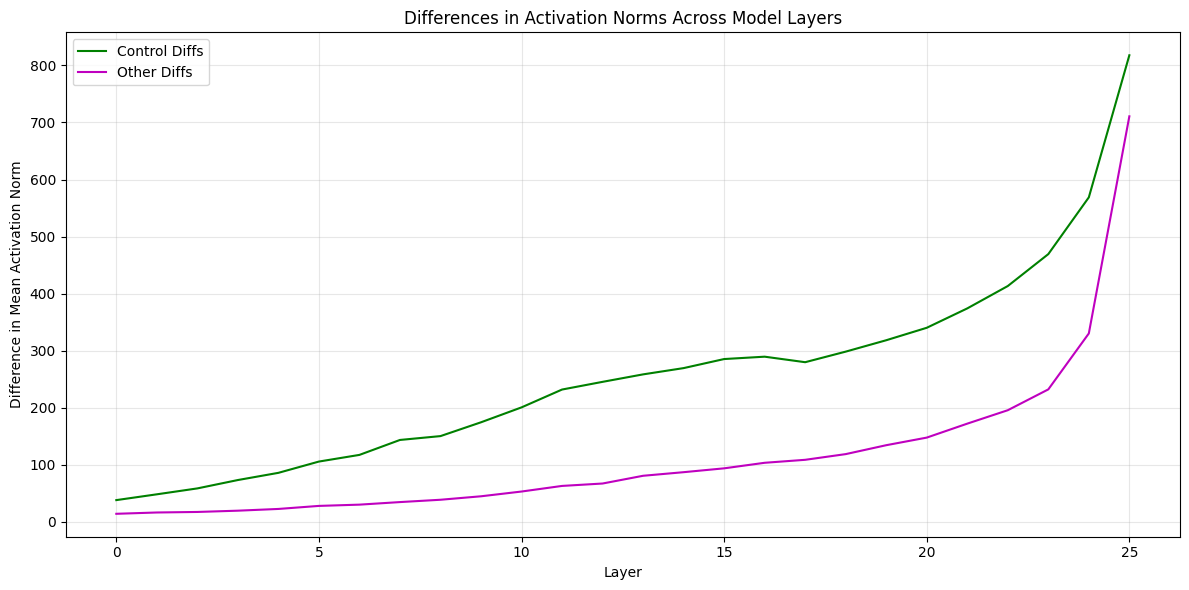

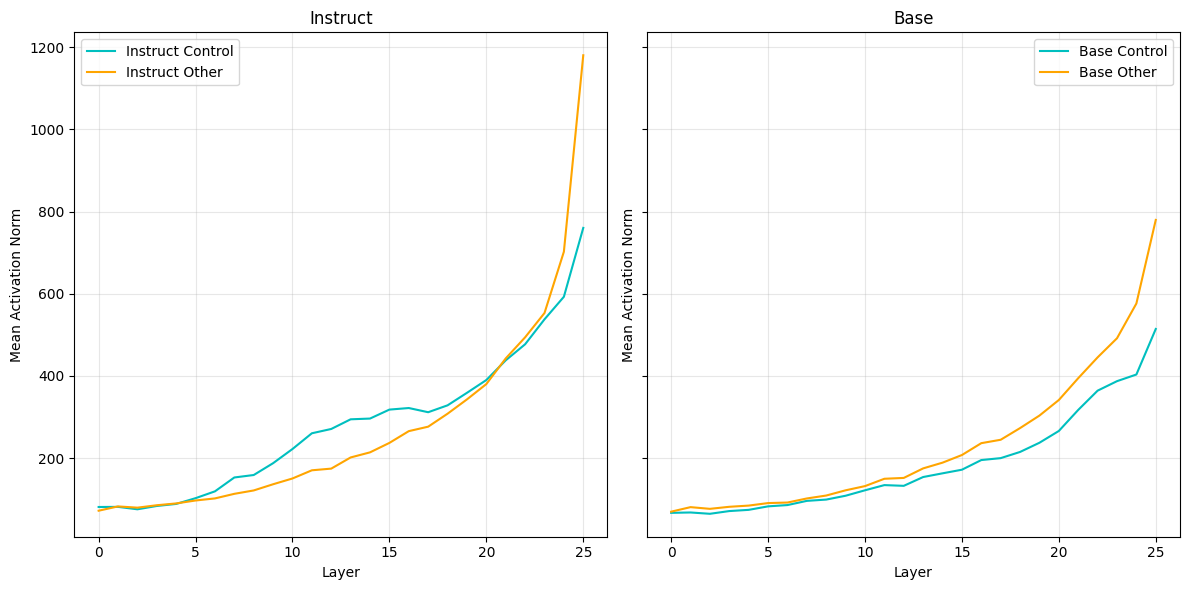

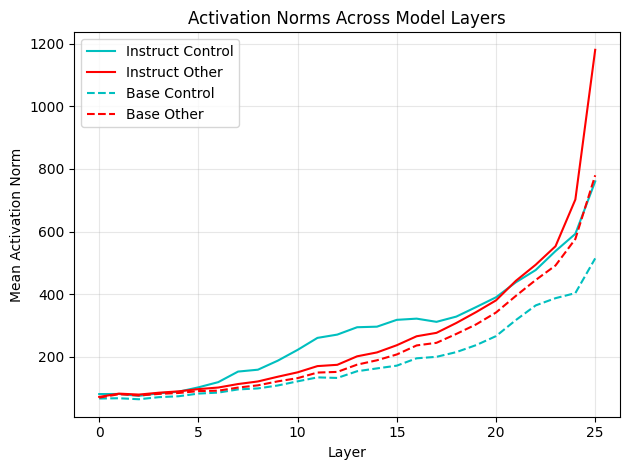

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract means for plotting
layers = list(range(num_layers))
it_control_means = [results[i]["it"]["control"].compute() for i in layers]
it_other_means = [results[i]["it"]["other"].compute() for i in layers]
it_other_no_bos_means = [results[i]["it"]["other_no_bos"].compute() for i in layers]
base_control_means = [results[i]["base"]["control"].compute() for i in layers]
base_other_means = [results[i]["base"]["other"].compute() for i in layers]
base_other_no_bos_means = [results[i]["base"]["other_no_bos"].compute() for i in layers]

# Create figure and axes for 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot lines for Instruct Control
axs[0].plot(layers, it_control_means, "b-", label="Instruct Control")
axs[0].plot(layers, base_control_means, "r-", label="Base Control")
axs[0].set_title("Instruct Control vs Base Control")
axs[0].set_xlabel("Layer")
axs[0].set_ylabel("Mean Activation Norm")
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Plot lines for Instruct Other
axs[1].plot(layers, it_other_means, "b", label="Instruct Other")
axs[1].plot(layers, base_other_means, "r", label="Base Other")
axs[1].set_title("Instruct Other vs Base Other")
axs[1].set_xlabel("Layer")
axs[1].grid(True, alpha=0.3)
axs[1].legend()

# Plot lines for Instruct Other No BOS
axs[2].plot(layers, it_other_no_bos_means, "b", label="Instruct Other No BOS")
axs[2].plot(layers, base_other_no_bos_means, "r", label="Base Other No BOS")
axs[2].set_title("Instruct Other No BOS vs Base Other No BOS")
axs[2].set_xlabel("Layer")
axs[2].grid(True, alpha=0.3)
axs[2].legend()

# Show plot
plt.tight_layout()
plt.show()

# Plot diffs
# Calculate the differences between means
control_diffs = [results[i]["diff"]["control"].compute() for i in layers]
other_diffs = [results[i]["diff"]["other"].compute() for i in layers]

# Plot the differences
plt.figure(figsize=(12, 6))
plt.plot(layers, control_diffs, "g", label="Control Diffs")
plt.plot(layers, other_diffs, "m", label="Other Diffs")

# Customize plot
plt.xlabel("Layer")
plt.ylabel("Difference in Mean Activation Norm")
plt.title("Differences in Activation Norms Across Model Layers")
plt.legend()
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

# plot grouped by model rather than layer
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].plot(layers, it_control_means, "c", label="Instruct Control")
axs[0].plot(layers, it_other_means, "orange", label="Instruct Other")
axs[1].plot(layers, base_control_means, "c", label="Base Control")
axs[1].plot(layers, base_other_means, "orange", label="Base Other")
axs[0].set_title("Instruct")
axs[1].set_title("Base")
axs[0].set_xlabel("Layer")
axs[1].set_xlabel("Layer")
axs[0].set_ylabel("Mean Activation Norm")
axs[1].set_ylabel("Mean Activation Norm")
axs[0].legend()
axs[1].legend()
axs[0].grid(True, alpha=0.3)
axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.plot(layers, it_control_means, "c", label="Instruct Control")
plt.plot(layers, it_other_means, "r", label="Instruct Other")
plt.plot(layers, base_control_means, "c--", label="Base Control")
plt.plot(layers, base_other_means, "r--", label="Base Other")
plt.xlabel("Layer")
plt.ylabel("Mean Activation Norm")
plt.title("Activation Norms Across Model Layers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# print the last tokens and control mask with color for control mask == 1
index = th.randint(0, len(batch["input_ids"]), (1,)).item()
for i in range(len(batch["input_ids"][index])):
    tok = it_model.tokenizer.decode(batch["input_ids"][index][i])
    if tok == "\n":
        tok = "\\n\n"
    if control_mask[index][i] == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")

<bos><start_of_turn>user\n
Structure a podcast script for an episode discussing the influence of streaming platforms on the music industry.<end_of_turn>\n
<start_of_turn>model\n
Sure, here's an example script for an episode discussing the influence of streaming platforms on the music industry:

Intro:\n
- Hi everyone, welcome to this episode of the Music Industry podcast where we'll be discussing the impact of streaming platforms on the music industry.

Body:\n
- Streaming platforms like Spotify, Apple Music, and Google Play have revolutionized the way people listen to music.\n
- With millions of subscribers and access to millions of songs, streaming platforms have changed the game for artists and musicians.\n
- Nowadays, artists can reach a wider audience and connect with fans on a personal level through streaming.\n
- And it's not just the number of subscribers that's important - streaming platforms also impact the music industry in other ways.

For example, streaming platforms give 

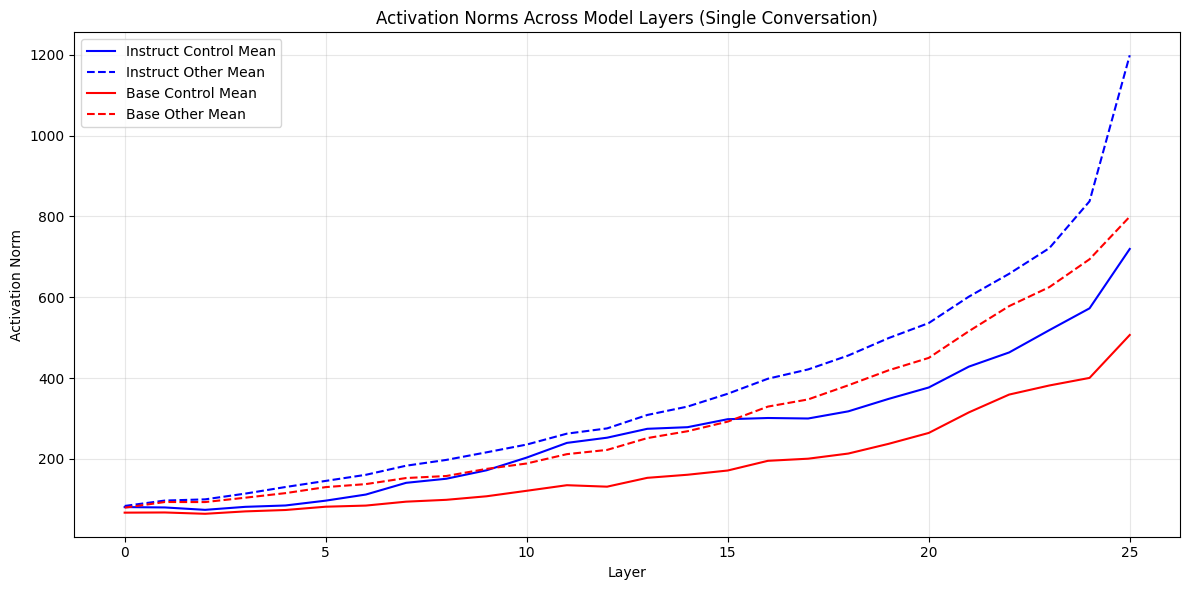

<bos><start_of_turn>user\n
Hello, how are you?<end_of_turn>\n
<start_of_turn>model\n
I am fine, thank you!<end_of_turn>\n
<start_of_turn>user\n
What is your name?<end_of_turn>\n
<start_of_turn>model\n
I am a chatbot.<end_of_turn>\n


In [10]:
import torch as th
from tqdm.auto import trange
from collections import defaultdict
import matplotlib.pyplot as plt
from nnterp.nnsight_utils import get_num_layers, get_layer_output
from tools.utils import tokenize_with_ctrl_mask

# Disable gradients
th.set_grad_enabled(False)

# Simple example conversation
conv = [
    {"role": "user", "content": "Hello, how are you?"},
    {"role": "assistant", "content": "I am fine, thank you!"},
    {"role": "user", "content": "What is your name?"},
    {"role": "assistant", "content": "I am a chatbot."},
]

num_layers = get_num_layers(it_model)
results = [defaultdict(lambda: defaultdict(list)) for _ in range(num_layers)]

# Prepare batch
batch = tokenize_with_ctrl_ids(
    [conv] * 2,
    it_model.tokenizer,
    return_dict=True,
    return_assistant_tokens_mask=True,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=1024,
)

# Create masks
control_mask = batch["ctrl_mask"]
other_mask = ~control_mask & batch["attention_mask"].bool()

# Run computation for instruction-tuned model
with it_model.trace(batch):
    for i in range(num_layers):
        it_norms = get_layer_output(it_model, i).norm(dim=-1).save()
        results[i]["it"]["control"].append(it_norms[control_mask].save())
        results[i]["it"]["other"].append(it_norms[other_mask].save())
# Run computation for base model
with base_model.trace(batch):
    for i in range(num_layers):
        base_norms = get_layer_output(base_model, i).norm(dim=-1).save()
        results[i]["base"]["control"].append(base_norms[control_mask].save())
        results[i]["base"]["other"].append(base_norms[other_mask].save())

# Extract means, mins, and maxes for plotting
layers = list(range(num_layers))
it_control_means = [results[i]["it"]["control"][0].mean().item() for i in layers]
it_other_means = [results[i]["it"]["other"][0].mean().item() for i in layers]
base_control_means = [results[i]["base"]["control"][0].mean().item() for i in layers]
base_other_means = [results[i]["base"]["other"][0].mean().item() for i in layers]

it_control_mins = [results[i]["it"]["control"][0].min().item() for i in layers]
it_other_mins = [results[i]["it"]["other"][0].min().item() for i in layers]
base_control_mins = [results[i]["base"]["control"][0].min().item() for i in layers]
base_other_mins = [results[i]["base"]["other"][0].min().item() for i in layers]

it_control_maxes = [results[i]["it"]["control"][0].max().item() for i in layers]
it_other_maxes = [results[i]["it"]["other"][0].max().item() for i in layers]
base_control_maxes = [results[i]["base"]["control"][0].max().item() for i in layers]
base_other_maxes = [results[i]["base"]["other"][0].max().item() for i in layers]

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(layers, it_control_means, "b-", label="Instruct Control Mean")
plt.plot(layers, it_other_means, "b--", label="Instruct Other Mean")
plt.plot(layers, base_control_means, "r-", label="Base Control Mean")
plt.plot(layers, base_other_means, "r--", label="Base Other Mean")

# plt.plot(layers, it_control_mins, 'b:', label='Instruct Control Min')
# plt.plot(layers, it_other_mins, 'b-.', label='Instruct Other Min')
# plt.plot(layers, base_control_mins, 'r:', label='Base Control Min')
# plt.plot(layers, base_other_mins, 'r-.', label='Base Other Min')

# plt.plot(layers, it_control_maxes, 'g-', label='Instruct Control Max')
# plt.plot(layers, it_other_maxes, 'g--', label='Instruct Other Max')
# plt.plot(layers, base_control_maxes, 'm-', label='Base Control Max')
# plt.plot(layers, base_other_maxes, 'm--', label='Base Other Max')

plt.xlabel("Layer")
plt.ylabel("Activation Norm")
plt.title("Activation Norms Across Model Layers (Single Conversation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the conversation with control tokens highlighted
for tok, mask in zip(batch["input_ids"][0], control_mask[0]):
    tok = it_model.tokenizer.decode(tok)
    if tok == "\n":
        tok = "\\n\n"
    if mask == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")
# create html object that

In [11]:
from tools.utils import activation_visualization
from IPython.display import HTML

HTML(
    activation_visualization(
        it_model.tokenizer.convert_ids_to_tokens(batch["input_ids"][0]),
        it_norms[0],
        it_model.tokenizer,
    )
)

## KL with control mask exp

### Get mean activations

In [12]:
from tools.utils import Mean1DMetric
m = Mean1DMetric(size=10)
m.update(th.full((10, 2, 10), 1))
m.update(th.full((10, 2, 10), 2))
new = th.full((10, 2, 10), 3)
new[:, :, :5] = -1
m.update(new)
m.compute()

tensor([0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000])

In [13]:
import random
data = lmsys_test["train"]["conversation"]
random.seed(26)
random.shuffle(data)
from tools.utils import tokenize_with_ctrl_ids

mean_acts = [
    defaultdict(lambda: Mean1DMetric(base_model.config.hidden_size))
    for _ in range(num_layers)
]
max_num_tokens = 10_000 if not TESTING else 100
pbar = tqdm(total=max_num_tokens, desc="Processing Tokens")
num_tokens = th.zeros(10)
for i in trange(0, len(data), batch_size, desc="Processing Batches"):
    batch_data = data[i : i + batch_size]
    batch = tokenize_with_ctrl_ids(
        batch_data,
        it_model.tokenizer,
        return_dict=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=1024,
    )
    control_ids = batch["ctrl_ids"].to(device_it)
    acts = [defaultdict(list) for _ in range(num_layers)]
    with it_model.trace(batch):
        for l in range(num_layers):
            for tok in range(1, 11):
                acts[l][tok] = get_layer_output(it_model, l)[control_ids == tok].cpu().save()
    for l in range(num_layers):
        for tok in range(1, 11):
            mean_acts[l][tok].update(acts[l][tok].value)
    new_num_tokens = th.tensor([(control_ids == i).sum().item() for i in range(1, 11)])
    num_tokens += new_num_tokens
    pbar.update(new_num_tokens.min().item())
    if num_tokens.min().item() >= max_num_tokens:
        break

Processing Tokens:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Batches:   0%|          | 0/12500 [00:00<?, ?it/s]

In [14]:
computed_mean_acts = [
    {tok: mean_acts[l][tok].compute() for tok in range(1, 11)}
    for l in range(num_layers)
]

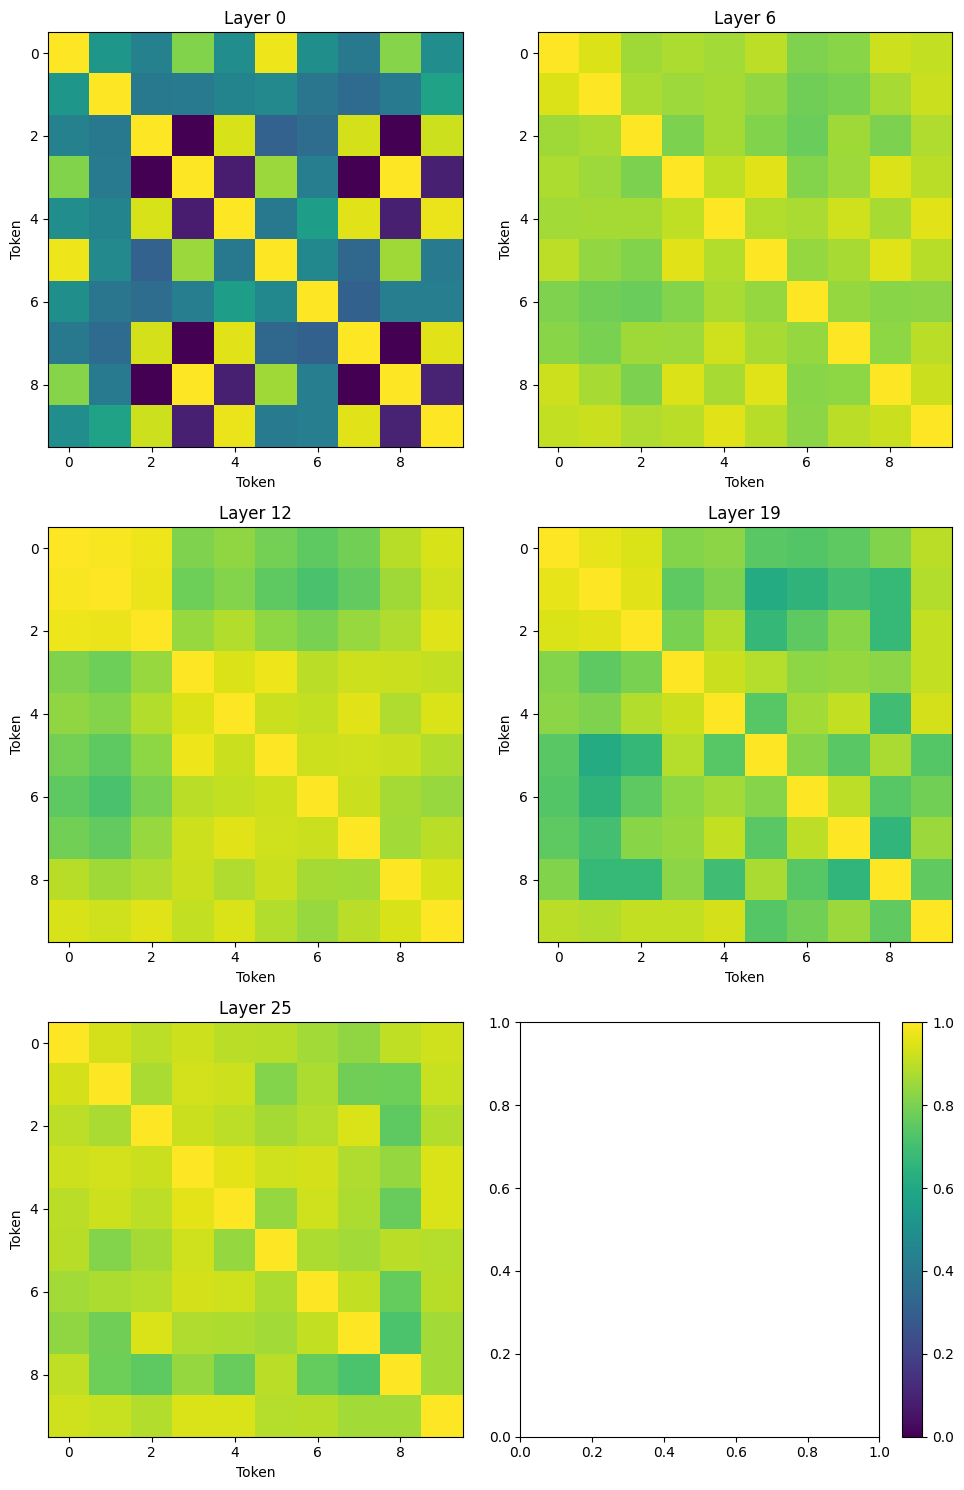

In [15]:
# compute cosim between each tokens on different plots for layers in linspace(0, num_layers - 1, 5)
from torch.nn.functional import cosine_similarity
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = axes.flatten()
for ax, layer in zip(axes, np.round(np.linspace(0, num_layers - 1, 5)).astype(int)):
    # cosim heatmap
    vects = th.stack(list(computed_mean_acts[layer].values()))
    cosim = cosine_similarity(vects.unsqueeze(0), vects.unsqueeze(1), dim=-1)
    im = ax.imshow(cosim, cmap="viridis", vmin=0, vmax=1)
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("Token")
    ax.set_ylabel("Token")
fig.colorbar(im, ax=axes[-1])
plt.tight_layout()
plt.show()


In [16]:
from tqdm.auto import trange
from collections import defaultdict
from nnterp.nnsight_utils import get_num_layers, get_layer_output, get_logits
from tools.utils import tokenize_with_ctrl_mask, compute_kl
from tools.utils import RunningMeanStd
import gc
import random

num_layers = get_num_layers(it_model)
batch_size = 8
max_num_tokens = 1_000_000 if not TESTING else 100
th.set_grad_enabled(False)
kl_means = defaultdict(RunningMeanStd)
num_tokens = 0
last_batch = i + batch_size  # no contamination with mean of control tokens

pbar = tqdm(total=max_num_tokens, desc="Processing Tokens")
for i in trange(last_batch, len(data), batch_size, desc="Processing Batches"):
    batch_data = data[i : i + batch_size]
    # run a forward pass on both pytorch models
    # Split models across GPUs
    batch = tokenize_with_ctrl_ids(
        batch_data,
        it_model.tokenizer,
        return_dict=True,
        return_assistant_tokens_mask=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=1024,
    )

    control_mask = batch["ctrl_mask"]
    control_ids = batch["ctrl_ids"].to(device_it)
    num_true_per_batch = control_mask.sum(dim=1)  # Get count per batch
    baseline_mask = th.zeros_like(control_mask)
    assistant_mask = th.tensor(batch["assistant_masks"], dtype=th.bool)
    logit_mask = (
        assistant_mask & ~control_mask & ~baseline_mask
    )  # remove tokens which will be patched

    # For each item in batch
    for b in range(control_mask.size(0)):
        # Get indices where control_mask is False for this batch item
        available_indices = th.where(~control_mask[b])[0]
        # Randomly select num_true indices from available positions
        selected = th.randperm(len(available_indices))[: num_true_per_batch[b]]
        baseline_mask[b, available_indices[selected]] = True
    if baseline_mask.sum() != control_mask.sum():
        print(
            f"Baseline mask has {baseline_mask.sum()} True values, expected {control_mask.sum()}"
        )
    it_control_mask = control_mask.to(device_it)
    it_baseline_mask = baseline_mask.to(device_it)

    base_control_mask = control_mask.to(device_base)
    base_baseline_mask = baseline_mask.to(device_base)
    it_ctrl_acts = []
    it_baseline_acts = []
    with it_model.trace(batch):
        it_logits = get_logits(it_model).cpu().save()
        for l in range(num_layers):
            it_ctrl_acts.append(
                get_layer_output(it_model, l)[it_control_mask].to(device_base).save()
            )
            it_baseline_acts.append(
                get_layer_output(it_model, l)[it_baseline_mask].to(device_base).save()
            )
    assert (
        it_ctrl_acts[0].shape == it_baseline_acts[0].shape
    ), f"Control and baseline activations have different shapes: {it_ctrl_acts[0].shape} vs {it_baseline_acts[0].shape}"
    kl_means["IT"].update(compute_kl(it_logits, it_logits, logit_mask, average_over_tokens=False))

    with base_model.trace(batch):
        clean_base_logits = get_logits(base_model).cpu().save()
    kl_means["Base"].update(compute_kl(clean_base_logits, it_logits, logit_mask, average_over_tokens=False))

    with base_model.trace(batch):
        for l in range(num_layers):
            get_layer_output(base_model, l)[base_control_mask] = it_ctrl_acts[l]
        itctrl_base_logits = get_logits(base_model).cpu().save()
    kl_means["Base-IT-Control"].update(compute_kl(itctrl_base_logits, it_logits, logit_mask, average_over_tokens=False))

    with base_model.trace(batch):
        for l in range(num_layers):
            get_layer_output(base_model, l)[base_baseline_mask] = it_baseline_acts[l]
        random_base_logits = get_logits(base_model).cpu().save()
    kl_means["Base-IT-Random"].update(compute_kl(random_base_logits, it_logits, logit_mask, average_over_tokens=False))

    control_ids = batch["ctrl_ids"].to(device_base)
    with it_model.trace(batch):
        it_logits = get_logits(it_model).cpu().save()
    with base_model.trace(batch):
        for l in range(num_layers):
            for tok in range(1, 11):
                get_layer_output(base_model, l)[control_ids == tok] = (
                    computed_mean_acts[l][tok].to(dtype=it_logits.dtype)
                )
        mean_itctrl_base_logits = get_logits(base_model).cpu().save()
    kl_means["Base-IT-MeanControl"].update(compute_kl(mean_itctrl_base_logits, it_logits, logit_mask, average_over_tokens=False))
    new_num_tokens = logit_mask.sum()
    num_tokens += new_num_tokens
    pbar.update(new_num_tokens.item())
    if num_tokens >= max_num_tokens:
        break

Processing Tokens:   0%|          | 0/1000000 [00:00<?, ?it/s]

Processing Batches:   0%|          | 0/11757 [00:00<?, ?it/s]

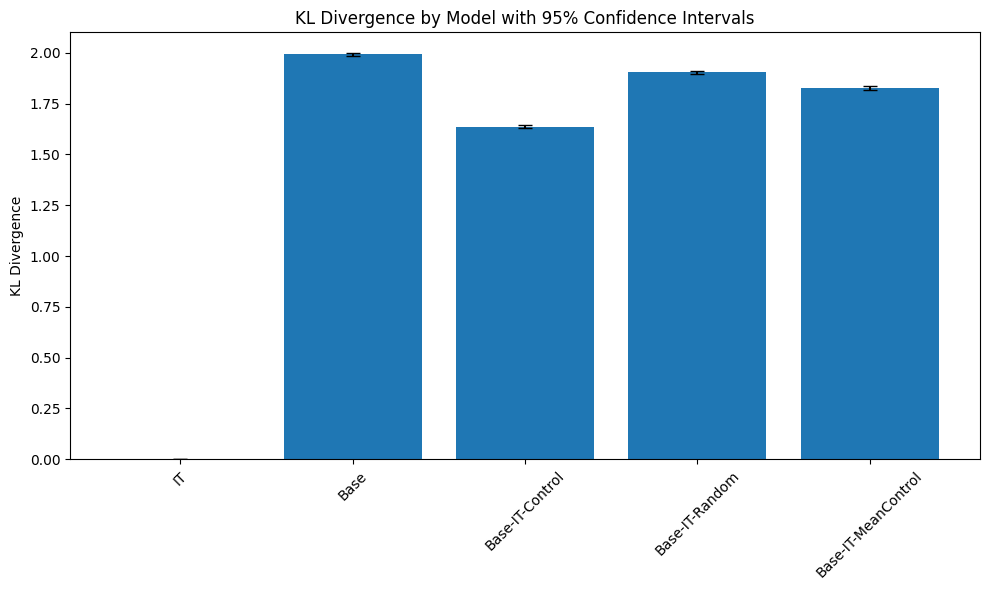

In [17]:
results_kl = {
    name: {
        "mean": kl_means[name].mean.item(),
        "std": kl_means[name].var.sqrt().item(),
        "count": kl_means[name].count,
    }
    for name in kl_means
}
path = Path("results/kl_base_edit.json")
path.parent.mkdir(parents=True, exist_ok=True)
with open(path, "w") as f:
    json.dump(results_kl, f)
# Calculate means and confidence intervals
means = {name: results_kl[name]["mean"] for name in results_kl}
cis = {
    name: 1.96 * results_kl[name]["std"] / np.sqrt(results_kl[name]["count"])
    for name in results_kl
}

# Create bar plot with error bars
plt.figure(figsize=(10, 6))
x = np.arange(len(means))
plt.bar(x, list(means.values()), yerr=list(cis.values()), capsize=5)
plt.xticks(x, list(means.keys()), rotation=45)
plt.ylabel("KL Divergence")
plt.title("KL Divergence by Model with 95% Confidence Intervals")
plt.tight_layout()
plt.show()

In [18]:
num_layers = get_num_layers(it_model)
batch_size = 8
max_num_tokens = 100_000 if not TESTING else 100
th.set_grad_enabled(False)
num_tokens = 0
layers = np.round(np.linspace(0, num_layers - 1, 5)).astype(int)
results_kl2 = {layer: defaultdict(RunningMeanStd) for layer in layers}

# pbar over token 1...max_num_tokens
pbar = tqdm(total=max_num_tokens, desc="Processing Tokens")
for i in trange(last_batch, len(data), batch_size, desc="Processing Batches"):
    batch_data = data[i : i + batch_size]
    # run a forward pass on both pytorch models
    # Split models across GPUs
    batch = tokenize_with_ctrl_ids(
        batch_data,
        it_model.tokenizer,
        return_dict=True,
        return_assistant_tokens_mask=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=1024,
    )

    control_mask = batch["ctrl_mask"]
    control_ids = batch["ctrl_ids"].to(device_base)
    num_true_per_batch = control_mask.sum(dim=1)  # Get count per batch
    baseline_mask = th.zeros_like(control_mask)
    assistant_mask = th.tensor(batch["assistant_masks"], dtype=th.bool)
    logit_mask = (
        assistant_mask & ~control_mask & ~baseline_mask
    )  # remove tokens which will be patched

    # For each item in batch
    for b in range(control_mask.size(0)):
        # Get indices where control_mask is False for this batch item
        available_indices = th.where(~control_mask[b])[0]
        # Randomly select num_true indices from available positions
        selected = th.randperm(len(available_indices))[: num_true_per_batch[b]]
        baseline_mask[b, available_indices[selected]] = True
    if baseline_mask.sum() != control_mask.sum():
        print(
            f"Baseline mask has {baseline_mask.sum()} True values, expected {control_mask.sum()}"
        )
    it_control_mask = control_mask.to(device_it)
    it_baseline_mask = baseline_mask.to(device_it)

    base_control_mask = control_mask.to(device_base)
    base_baseline_mask = baseline_mask.to(device_base)
    it_ctrl_acts = []
    it_baseline_acts = []
    with it_model.trace(batch):
        it_logits = get_logits(it_model).cpu().save()
        for l in range(num_layers):
            it_ctrl_acts.append(
                get_layer_output(it_model, l)[it_control_mask].to(device_base).save()
            )
            it_baseline_acts.append(
                get_layer_output(it_model, l)[it_baseline_mask].to(device_base).save()
            )
    assert (
        it_ctrl_acts[0].shape == it_baseline_acts[0].shape
    ), f"Control and baseline activations have different shapes: {it_ctrl_acts[0].shape} vs {it_baseline_acts[0].shape}"
    for layer in layers:
        with base_model.trace(batch):
            clean_acts = get_layer_output(base_model, layer).to(device_it).save()
            get_layer_output(base_model, layer).stop()
        with it_model.trace(batch):
            get_layer_output(it_model, layer)[:] = clean_acts
            clean_base_logits = get_logits(it_model).cpu().save()
        results_kl2[layer]["Base -> IT"].update(
            compute_kl(clean_base_logits, it_logits, logit_mask, average_over_tokens=False)
        )

        with base_model.trace(batch):
            for l in range(layer):
                get_layer_output(base_model, l)[base_control_mask] = it_ctrl_acts[l]
            itctrl_base_acts = get_layer_output(base_model, layer).to(device_it).save()
            get_layer_output(base_model, layer).stop()
        with it_model.trace(batch):
            get_layer_output(it_model, layer)[:] = itctrl_base_acts
            itctrl_base_logits = get_logits(it_model).cpu().save()
        results_kl2[layer]["Base-IT-Control -> IT"].update(
            compute_kl(itctrl_base_logits, it_logits, logit_mask, average_over_tokens=False)
        )

        with base_model.trace(batch):
            for l in range(layer):
                get_layer_output(base_model, l)[base_baseline_mask] = it_baseline_acts[
                    l
                ]
            random_base_acts = get_layer_output(base_model, layer).to(device_it).save()
            get_layer_output(base_model, layer).stop()
        with it_model.trace(batch):
            get_layer_output(it_model, layer)[:] = random_base_acts
            random_base_logits = get_logits(it_model).cpu().save()
        results_kl2[layer]["Base-IT-Random -> IT"].update(
            compute_kl(random_base_logits, it_logits, logit_mask, average_over_tokens=False)
        )

        with base_model.trace(batch):
            for tok in range(1, 11):
                get_layer_output(base_model, layer)[control_ids == tok] = (
                    computed_mean_acts[layer][tok].to(dtype=it_logits.dtype)
                )
            mean_base_acts = get_layer_output(base_model, layer).to(device_it).save()
            get_layer_output(base_model, layer).stop()
        with it_model.trace(batch):
            get_layer_output(it_model, layer)[:] = mean_base_acts
            mean_base_logits = get_logits(it_model).cpu().save()
        results_kl2[layer]["Base-IT-MeanControl -> IT"].update(
            compute_kl(mean_base_logits, it_logits, logit_mask, average_over_tokens=False)
        )
    new_num_tokens = logit_mask.sum()
    num_tokens += new_num_tokens
    pbar.update(new_num_tokens.item())
    if num_tokens >= max_num_tokens:
        break

Processing Tokens:   0%|          | 0/100000 [00:00<?, ?it/s]

Processing Batches:   0%|          | 0/11757 [00:00<?, ?it/s]

In [19]:
path = Path("results/kl_base_edit_to_it.json")
path.parent.mkdir(parents=True, exist_ok=True)

with open(path, "w") as f:
    json.dump(
        {
            int(i): {
                name: {
                    "mean": results_kl2[i][name].mean.item(),
                    "std": results_kl2[i][name].var.sqrt().item(),
                    "count": results_kl2[i][name].count,
                }
                for name in results_kl2[i]
            }
            for i in layers
        },
        f,
    )

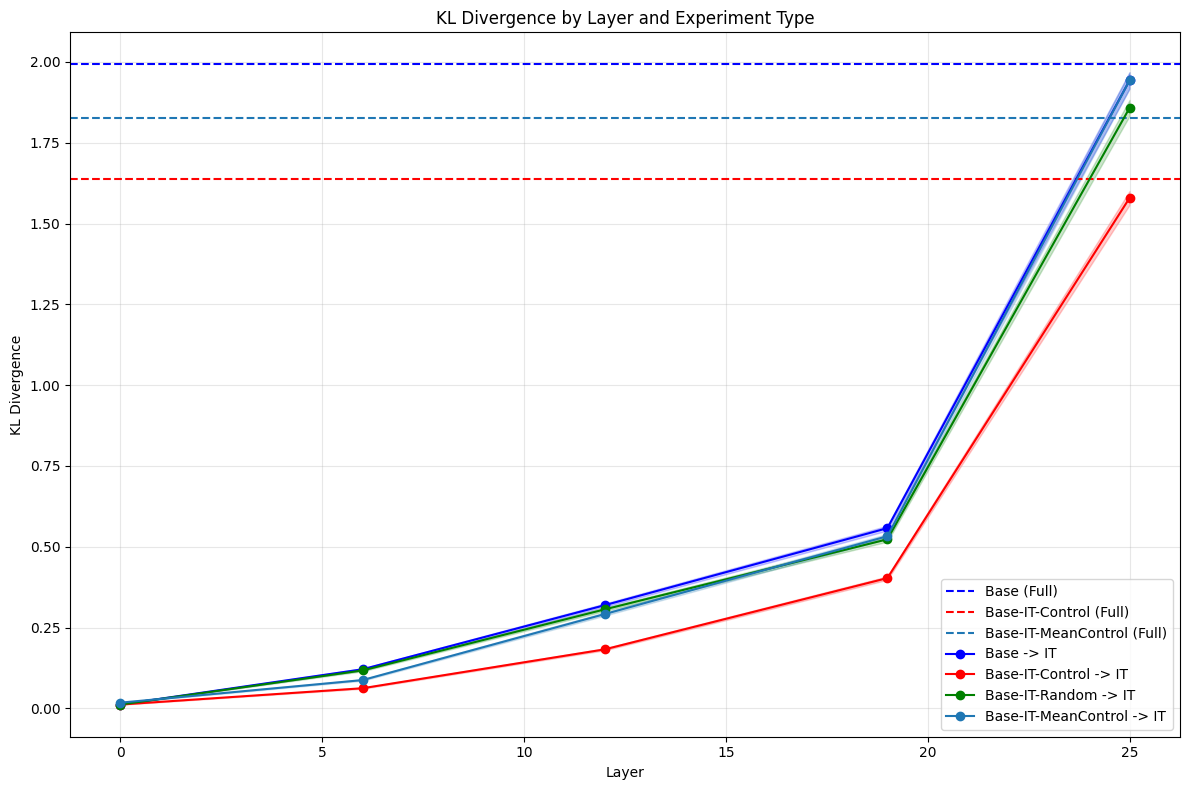

In [20]:
# Convert results to numpy arrays and calculate statistics
means = {
    layer: {name: results_kl2[layer][name].mean.item() for name in results_kl2[layer]}
    for layer in layers
}
cis = {
    layer: {
        name: 1.96
        * results_kl2[layer][name].var.sqrt().item()
        / np.sqrt(results_kl2[layer][name].count)
        for name in results_kl2[layer]
    }
    for layer in layers
}
# Create line plot
plt.figure(figsize=(12, 8))

# Plot horizontal lines from previous results
plt.axhline(
    y=np.mean(results_kl["Base"]["mean"]), color="b", linestyle="--", label="Base (Full)"
)
plt.axhline(
    y=np.mean(results_kl["Base-IT-Control"]["mean"]),
    color="r",
    linestyle="--",
    label="Base-IT-Control (Full)",
)
plt.axhline(
    y=np.mean(results_kl["Base-IT-MeanControl"]["mean"]),
    color="tab:blue",
    linestyle="--",
    label="Base-IT-MeanControl (Full)",
)

# Plot lines for each experiment
colors = ["b", "r", "g", "tab:blue"]
for exp_name, color in zip(results_kl2[layers[0]].keys(), colors):
    # Extract means and CIs for this experiment across layers
    exp_means = [means[layer][exp_name] for layer in layers]
    exp_cis = [cis[layer][exp_name] for layer in layers]

    # Plot line with confidence intervals
    plt.plot(layers, exp_means, color=color, label=exp_name, marker="o")
    plt.fill_between(
        layers,
        np.array(exp_means) - np.array(exp_cis),
        np.array(exp_means) + np.array(exp_cis),
        color=color,
        alpha=0.2,
    )

plt.xlabel("Layer")
plt.ylabel("KL Divergence")
plt.title("KL Divergence by Layer and Experiment Type")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

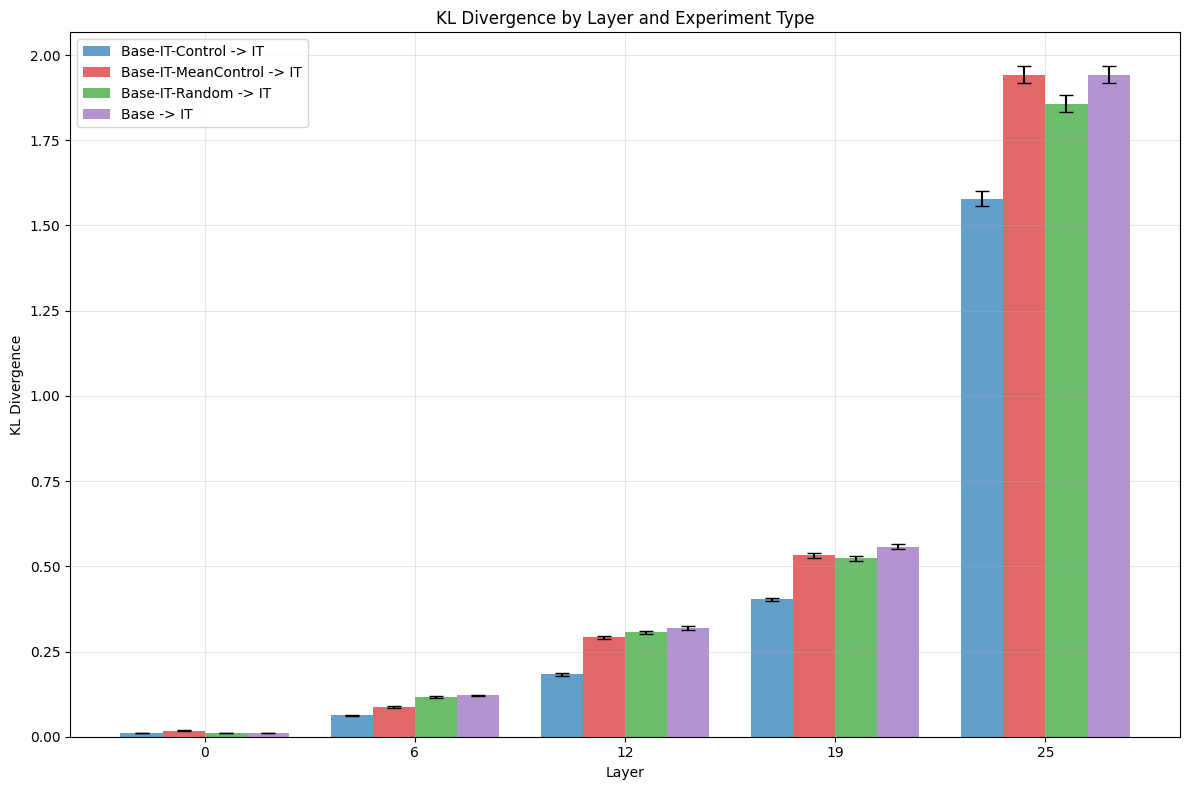

In [19]:
# Convert results to numpy arrays and calculate statistics
loaded_dict = json.load(open("results/kl_base_edit_to_it.json"))
results_kl = json.load(open("results/kl_base_edit.json"))
means = {
    layer: {name: loaded_dict[layer][name]["mean"] for name in loaded_dict[layer]}
    for layer in loaded_dict
}
layers = list(loaded_dict.keys())
cis = {
    layer: {
        name: 1.96
        * loaded_dict[layer][name]["std"]
        / np.sqrt(loaded_dict[layer][name]["count"])
        for name in loaded_dict[layer]
    }
    for layer in loaded_dict
}

# Create subplot grid
plt.figure(figsize=(12, 8))

# Number of experiments
n_exps = len(loaded_dict[layers[0]].keys())
bar_width = 0.8 / n_exps
# Plot bars for each layer and experiment
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple"]
x = np.arange(len(layers))
exps = list(loaded_dict[layers[0]].keys())
exps = [exps[1], exps[3], exps[2], exps[0]]
for i, (exp_name, color) in enumerate(zip(exps, colors)):
    # Extract means and CIs for this experiment across layers
    exp_means = [means[layer][exp_name] for layer in layers]
    exp_cis = [cis[layer][exp_name] for layer in layers]
    
    # Calculate bar positions
    bar_pos = x + i * bar_width - (n_exps-1) * bar_width/2
    
    # Plot bars with error bars
    plt.bar(bar_pos, exp_means, bar_width, label=exp_name, color=color, alpha=0.7)
    plt.errorbar(bar_pos, exp_means, yerr=exp_cis, fmt='none', color='black', capsize=5)

plt.xlabel("Layer")
plt.ylabel("KL Divergence")
plt.title("KL Divergence by Layer and Experiment Type")
plt.xticks(x, layers)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()